<a href="https://colab.research.google.com/github/SkeletonKing240/My-Projects/blob/main/IBowens_Movie_Recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [143]:
# uncomment if you are using google colab

#from google.colab import drive
#drive.mount('/content/drive/ratings.csv')

In [144]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [145]:
# Used to ignore the warning given as output of the code
import warnings                                 
warnings.filterwarnings('ignore')

# Basic libraries of python for numeric and dataframe computations
import numpy as np                              
import pandas as pd

# Basic library for data visualization
import matplotlib.pyplot as plt     

# Slightly advanced library for data visualization            
import seaborn as sns                           

# A dictionary output that does not raise a key error
from collections import defaultdict             

# A performance metrics in surprise
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For model tuning model hyper-parameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test dataset
from surprise.model_selection import train_test_split

# For implementing similarity based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# For implementing cross validation
from surprise.model_selection import KFold

In [146]:
# Import the dataset
rating = pd.read_csv('/ratings.csv')

In [147]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [148]:
# Dropping timestamp column
rating = rating.drop(['timestamp'], axis=1)

In [149]:
rating.head(5)

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [150]:
rating.tail(5)

,userId,movieId,rating
99999,671,6268,2.5
100000,671,6269,4.0
100001,671,6365,4.0
100002,671,6385,2.5
100003,671,6565,3.5


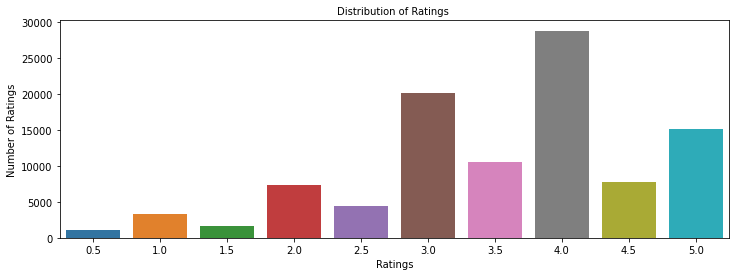

In [151]:
plt.figure(figsize = (12, 4))


sns.countplot(x="rating", data = rating)

plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.show()

In [152]:
rating['userId'].nunique()

671

In [153]:
rating['movieId'].nunique()

9066

In [154]:
rating.groupby(['userId', 'movieId']).count()
#no items in which users interacted with more than once here.

rating
userId movieId        
1      31            1
       1029          1
       1061          1
       1129          1
       1172          1
...                ...
671    6268          1
       6269          1
       6365          1
       6385          1
       6565          1

[100004 rows x 1 columns]

In [155]:
rating.groupby(['userId', 'movieId']).count()['rating'].sum()

100004

In [156]:
rating['movieId'].value_counts()
#movie number 356 has been interacted with by users the most.
#However, 671-356= 315 users that still have yet to interact with this data. 
#Therefore we must create a recommendation system in order to predict
#who is most likely to interact with them.

356       341
296       324
318       311
593       304
260       291
         ... 
98604       1
103659      1
104419      1
115927      1
6425        1
Name: movieId, Length: 9066, dtype: int64

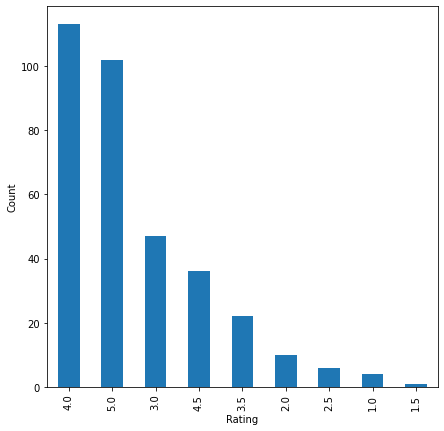

In [157]:
# Plotting distributions of ratings for 341 interactions with movieid 356 
plt.figure(figsize=(7,7))

rating[rating['movieId'] == 356]['rating'].value_counts().plot(kind='bar')

plt.xlabel('Rating')

plt.ylabel('Count')

plt.show()

In [158]:
rating['userId'].value_counts()
#User number 547 has interacted with the most amount of items here. However there are still 6675
#interactions still possible. 9066-2391=6675

547    2391
564    1868
624    1735
15     1700
73     1610
       ... 
296      20
289      20
249      20
221      20
1        20
Name: userId, Length: 671, dtype: int64

In [159]:
# Finding user-movie interactions distribution
count_interactions = rating.groupby('userId').count()['movieId']
count_interactions

userId
1       20
2       76
3       51
4      204
5      100
      ... 
667     68
668     20
669     37
670     31
671    115
Name: movieId, Length: 671, dtype: int64

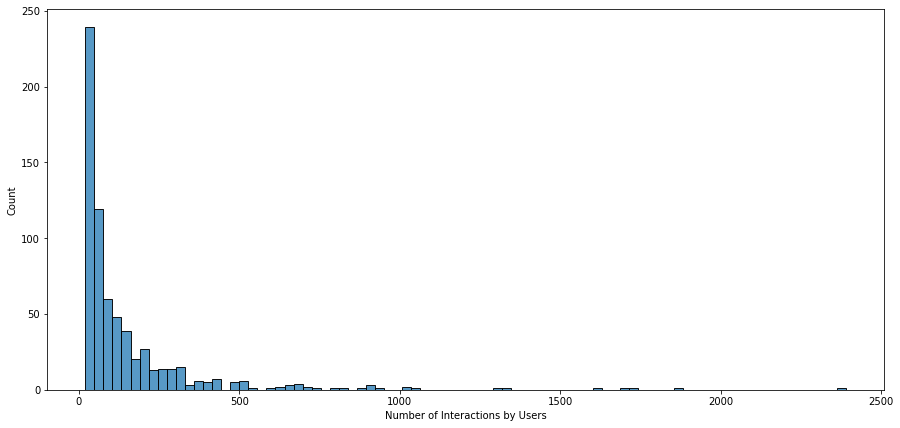

In [160]:
# Plotting user-movie interactions distribution

plt.figure(figsize=(15,7))

sns.histplot(count_interactions)

plt.xlabel('Number of Interactions by Users')

plt.show()
#This is not normal distributuon, almost no user interacted with more than 500 items here,
#Skewed to the right.

In [161]:
# Calculating average ratings
average_rating = rating.groupby('movieId').mean()['rating']

# Calculating the count of ratings
count_rating = rating.groupby('movieId').count()['rating']

# Making a dataframe with the count and average of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

In [162]:
final_rating.head()
#The average rating is around a 3.5

,avg_rating,rating_count
movieId,,
1,3.872470,247
2,3.401869,107
3,3.161017,59
4,2.384615,13
5,3.267857,56


In [163]:
def top_n_movies(data, n, min_interaction=100):
    
    #Finding movies with minimum number of interactions
    recommendations = data[data['rating_count'] >= min_interaction]
    
    #Sorting values w.r.t average rating 
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)
    
    return recommendations.index[:n]

In [164]:
list(top_n_movies(final_rating, 5, 50))
#Recommended the top 5 products by using the popularity recommendation system.

[858, 318, 969, 913, 1221]

In [165]:
list(top_n_movies(final_rating, 5, 100))

[858, 318, 1221, 50, 527]

In [166]:
list(top_n_movies(final_rating, 5, 200))

[858, 318, 50, 527, 608]

In [167]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [168]:
sim_options = {'name': 'cosine',
               'user_based': True}

# Defining Nearest neighbour algorithm
algo_knn_user = KNNBasic(sim_options=sim_options,verbose=False)

# Train the algorithm on the trainset or fitting the model on train dataset 
algo_knn_user.fit(trainset)

# Predict ratings for the testset
predictions = algo_knn_user.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.9925


0.9924509041520163

In [169]:
#The userbased model has RMSE=0.9925 on test set, I will try to 
#improve this number later by using GridSearchCV tuning different hyperparameters of this algorithm

In [170]:
algo_knn_user.predict(4, 10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.62   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.6244912065910952, details={'actual_k': 40, 'was_impossible': False})

In [171]:
#The actual rating for this user-item pair is 4 and predicted rating is 3.62 by this similarity based baseline model

In [172]:
algo_knn_user.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.20   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.202703552548654, details={'actual_k': 40, 'was_impossible': False})

In [173]:
#As we can see the estimated rating for this user-item pair is 3.2 based on this similarity based baseline model

In [174]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
}
# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
grid_obj.fit(data)

# Best RMSE score
print(grid_obj.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

0.9642240800036889
{'k': 20, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': True}}


In [175]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,0.963717,0.963053,0.965902,0.964224,0.001217,1,0.740644,0.739588,0.743582,0.741271,0.001690,1,0.175295,0.039336,3.026407,0.143274,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': True}"
1,0.991750,0.992144,0.994771,0.992889,0.001341,12,0.766672,0.766352,0.769696,0.767573,0.001507,12,0.639477,0.041330,3.164199,0.073884,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': True}"
2,0.969562,0.966388,0.970759,0.968903,0.001844,4,0.745360,0.742784,0.746849,0.744998,0.001679,3,0.153918,0.058984,3.138639,0.148027,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'msd', 'user_based': True}"
3,0.996142,0.994210,0.998294,0.996215,0.001668,15,0.770257,0.768444,0.771917,0.770206,0.001418,15,0.700614,0.123565,3.094702,0.055956,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'cosine', 'user_based': True}"
4,0.976319,0.970772,0.975577,0.974223,0.002458,7,0.750996,0.746570,0.750924,0.749497,0.002070,6,0.113104,0.008382,3.321771,0.089539,"{'k': 20, 'min_k': 9, 'sim_options': {'name': ...",20,9,"{'name': 'msd', 'user_based': True}"


In [176]:
# Using the optimal similarity measure for user-user based collaborative filtering
# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_user = KNNBasic(sim_options=sim_options, k=40, min_k=6,verbose=False)

# Training the algorithm on the trainset
similarity_algo_optimized_user.fit(trainset)

# Predicting ratings for the testset
predictions = similarity_algo_optimized_user.test(testset)

# Computing RMSE on testset
accuracy.rmse(predictions)

RMSE: 0.9908


0.9907613369496804

In [177]:
#After tuning hyperparameters, RMSE for testset was reduced to 0.990 from 0.992. 
#We've been able to improve the model after hyperparameter tuning

In [178]:
similarity_algo_optimized_user.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.62   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.6244912065910952, details={'actual_k': 40, 'was_impossible': False})

In [181]:
#predicted rating is still 3.6

In [182]:
similarity_algo_optimized_user.predict(4,3, r_ui=4, verbose=True)

user: 4          item: 3          r_ui = 4.00   est = 3.20   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=4, est=3.202703552548654, details={'actual_k': 40, 'was_impossible': False})

In [183]:
#predicted rating is 3.2

In [184]:
similarity_algo_optimized_user.get_neighbors(4, k=5)

[357, 220, 590, 491, 647]

In [185]:
def get_recommendations(data, user_id, top_n, algo):
    
    # Creating an empty list to store the recommended movie ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')
    
    # Extracting those movie ids which the user_id has not interacted yet
    non_interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the movie id which user_id has not interacted yet
    for item_id in non_interacted_movies:
        
        # Predicting the ratings for those non interacted movie ids by this user
        est = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # returing top n highest predicted rating movies for this user

In [186]:
recommendations = get_recommendations(rating,4,5,similarity_algo_optimized_user)

In [187]:
recommendations

[(98491, 4.832340578646058),
 (116, 4.753206589295344),
 (6669, 4.748048450384675),
 (1221, 4.662571141751736),
 (1192, 4.65824768595177)]

In [188]:
# Definfing similarity measure
sim_options = {'name': 'cosine',
               'user_based': False}

# Defining Nearest neighbour algorithm
algo_knn_item = KNNBasic(sim_options = sim_options,verbose=False)

# Train the algorithm on the trainset or fitting the model on train dataset 
algo_knn_item.fit(trainset)

# Predict ratings for the testset
predictions = algo_knn_item.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 1.0032


1.003221450633729

In [ ]:
#RMSE prediction is now at a 1.0

In [192]:
algo_knn_item.predict(4,10, r_ui=4, verbose=True)
#Prediction at a 4.7

user: 4          item: 10         r_ui = 4.00   est = 4.37   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.373794871885004, details={'actual_k': 40, 'was_impossible': False})

In [193]:
algo_knn_item.predict(4,3, r_ui=4, verbose=True)
#Prediction at 4.07

user: 4          item: 3          r_ui = 4.00   est = 4.07   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=4, est=4.071601862880049, details={'actual_k': 40, 'was_impossible': False})

In [191]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30,40], 'min_k': [3,6,9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
grid_obj.fit(data)

# Best RMSE score
print(grid_obj.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

0.9407212933038641
{'k': 40, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': False}}


In [ ]:
#RMSE now at 0.940

In [194]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,0.946926,0.956032,0.953925,0.952294,0.003892,7,0.731088,0.738816,0.736475,0.735459,0.003236,7,8.737258,0.238957,13.771220,2.345924,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': False}"
1,1.007105,1.016786,1.018809,1.014233,0.005108,16,0.786174,0.792998,0.793775,0.790982,0.003415,16,20.966810,0.257282,11.057994,0.779009,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': False}"
2,0.947337,0.956253,0.954532,0.952707,0.003862,8,0.731358,0.739040,0.737066,0.735821,0.003258,8,6.579100,0.333753,12.038241,0.611711,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'msd', 'user_based': False}"
3,1.007496,1.016879,1.019403,1.014593,0.005123,17,0.786434,0.793194,0.794351,0.791326,0.003491,17,19.208849,0.518381,13.644382,3.196526,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'cosine', 'user_based': False}"
4,0.947995,0.956849,0.955061,0.953302,0.003823,9,0.731810,0.739531,0.737519,0.736287,0.003270,9,7.001685,0.838158,12.985829,2.306480,"{'k': 20, 'min_k': 9, 'sim_options': {'name': ...",20,9,"{'name': 'msd', 'user_based': False}"


In [195]:
# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_item = KNNBasic(sim_options={'name': 'msd', 'user_based': False}, k=30, min_k=6,verbose=False)

# Training the algorithm on the trainset
similarity_algo_optimized_item.fit(trainset)

# Predicting ratings for the testset
predictions = similarity_algo_optimized_item.test(testset)

# Computing RMSE on testset
accuracy.rmse(predictions)
#I can see from above that after tuning hyperparameters, RMSE for testset has reduced to 0.94 from 1.00. 
#I can say that I've been able to improve the model after hyperparameter tuning.

RMSE: 0.9465


0.9465120620317036

In [196]:
similarity_algo_optimized_item.predict(4,3, r_ui=4, verbose=True)
#Prediction rating at 3.86

user: 4          item: 3          r_ui = 4.00   est = 3.86   {'actual_k': 30, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=4, est=3.859023126306401, details={'actual_k': 30, 'was_impossible': False})

In [197]:
similarity_algo_optimized_item.predict(4,10, verbose=True)
#Prediction Rating at 4.30

user: 4          item: 10         r_ui = None   est = 4.30   {'actual_k': 30, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=None, est=4.298279280483517, details={'actual_k': 30, 'was_impossible': False})

In [198]:
similarity_algo_optimized_item.get_neighbors(4, k=5)

[77, 85, 115, 119, 127]

In [199]:
recommendations = get_recommendations(rating, 4, 5, similarity_algo_optimized_item)

In [200]:
recommendations

[(84, 5), (1040, 5), (2481, 5), (3515, 5), (4521, 5)]

In [201]:
#Q4 Build a baseline matrix factorization recommendation system
# Using SVD matrix factorization
algo_svd = SVD()

# Training the algorithm on the trainset
algo_svd.fit(trainset)

# Predicting ratings for the testset
predictions = algo_svd.test(testset)

# Computing RMSE on the testset
accuracy.rmse(predictions)
#RMSE went down again, from a 9.4, to now a 9.0. We are making good progress

RMSE: 0.9034


0.9034028823091843

In [202]:
#Q5
#The RMSE basline is .9034

In [203]:
algo_svd.predict(4, 10, r_ui=4, verbose=True)
#The prediction rating is at 4.25, yet the actual rating is at 4.0, meaning there was some over estimations that need fixing 

user: 4          item: 10         r_ui = 4.00   est = 4.25   {'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.246526112248592, details={'was_impossible': False})

In [204]:
algo_svd.predict(4, 3, verbose=True)
#The prediction rating is at 3.66

user: 4          item: 3          r_ui = None   est = 3.66   {'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.6568432835359705, details={'was_impossible': False})

In [205]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross validation
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8939872970472081
{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}


In [206]:
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_epochs,param_lr_all,param_reg_all
0,0.942191,0.940624,0.945487,0.942767,0.002027,25,0.737002,0.735001,0.740877,0.737627,0.002439,25,5.268320,0.382938,0.583537,0.038405,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.2}",10,0.001,0.2
1,0.946913,0.945709,0.949931,0.947517,0.001776,26,0.742044,0.740437,0.746255,0.742912,0.002453,26,4.829454,0.378531,0.563145,0.054316,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.4}",10,0.001,0.4
2,0.952293,0.951057,0.955332,0.952894,0.001796,27,0.747963,0.746339,0.752336,0.748879,0.002533,27,5.494892,0.670732,0.718864,0.249165,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.6}",10,0.001,0.6
3,0.908398,0.904513,0.908718,0.907210,0.001911,11,0.701510,0.699422,0.704838,0.701923,0.002230,9,4.771349,0.077875,0.602231,0.030518,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.2}",10,0.005,0.2
4,0.914976,0.911988,0.915710,0.914225,0.001610,15,0.708739,0.707168,0.712977,0.709628,0.002453,15,4.665801,0.268043,0.507985,0.042122,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}",10,0.005,0.4


In [209]:
# Building the optimized SVD model using optimal hyperparameter search
svd_algo_optimized = SVD(n_epochs=30, lr_all=0.01, reg_all=.2)

# Training the algorithm on the trainset
svd_algo_optimized.fit(trainset)

# Predicting ratings for the testset
predictions = svd_algo_optimized.test(testset)

# Computing RMSE
accuracy.rmse(predictions)

RMSE: 0.8954


0.8953958410257875

In [210]:
svd_algo_optimized.predict(4, 10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.98   {'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.9846691828075724, details={'was_impossible': False})

In [212]:
svd_algo_optimized.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.64   {'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.642343162266116, details={'was_impossible': False})

In [213]:
get_recommendations(rating, 4, 5, svd_algo_optimized)

[(1192, 4.977556401356301),
 (116, 4.9646529540934665),
 (926, 4.951891579793339),
 (5114, 4.93986376413781),
 (3310, 4.924802214428187)]

In [214]:
def predict_already_interacted_ratings(data, user_id, algo):
    
    # Creating an empty list to store the recommended movie ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')
    
    # Extracting those movie ids which the user_id has interacted already
    interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].notnull()].index.tolist()
    
    # Looping through each of the movie id which user_id has interacted already
    for item_id in interacted_movies:
        
        # Extracting actual ratings
        actual_rating = user_item_interactions_matrix.loc[user_id, item_id]
        
        # Predicting the ratings for those non interacted movie ids by this user
        predicted_rating = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, actual_rating, predicted_rating))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return pd.DataFrame(recommendations, columns=['movieId', 'actual_rating', 'predicted_rating']) # returing top n highest predicted rating movies for this user

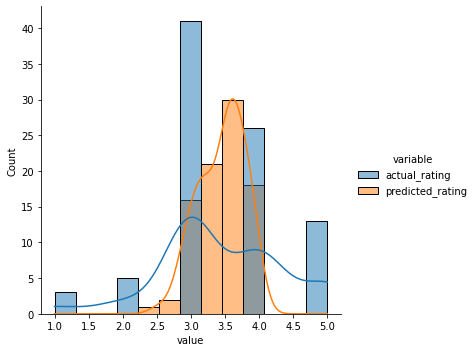

In [215]:
predicted_ratings_for_interacted_movies = predict_already_interacted_ratings(rating, 7, similarity_algo_optimized_item)
df = predicted_ratings_for_interacted_movies.melt(id_vars='movieId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=df, x='value', hue='variable', kde=True);

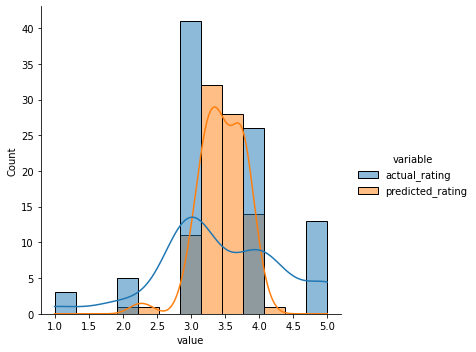

In [216]:
predicted_ratings_for_interacted_movies = predict_already_interacted_ratings(rating, 7, svd_algo_optimized)
df = predicted_ratings_for_interacted_movies.melt(id_vars='movieId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=df, x='value', hue='variable', kde=True);

In [217]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [218]:
# Function can be found on surprise documentation FAQs
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [220]:
# A basic cross-validation iterator.
kf = KFold(n_splits=5)

# Make list of k values
K = [5, 10]

# Make list of models
models = [algo_knn_user, similarity_algo_optimized_user,algo_knn_item,similarity_algo_optimized_item, algo_svd, svd_algo_optimized]

for k in K:
    for model in models:
        print('> k={}, model={}'.format(k,model.__class__.__name__))
        p = []
        r = []
        for trainset, testset in kf.split(data):
            model.fit(trainset)
            predictions = model.test(testset, verbose=False)
            precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5)

            # Precision and recall can then be averaged over all users
            p.append(sum(prec for prec in precisions.values()) / len(precisions))
            r.append(sum(rec for rec in recalls.values()) / len(recalls))
        
        print('-----> Precision: ', round(sum(p) / len(p), 3))
        print('-----> Recall: ', round(sum(r) / len(r), 3))

> k=5, model=KNNBasic
-----> Precision:  0.768
-----> Recall:  0.41
> k=5, model=KNNBasic
-----> Precision:  0.769
-----> Recall:  0.42
> k=5, model=KNNBasic
-----> Precision:  0.612
-----> Recall:  0.327
> k=5, model=KNNBasic
-----> Precision:  0.686
-----> Recall:  0.358
> k=5, model=SVD
-----> Precision:  0.757
-----> Recall:  0.386
> k=5, model=SVD
-----> Precision:  0.747
-----> Recall:  0.384
> k=10, model=KNNBasic
-----> Precision:  0.75
-----> Recall:  0.549
> k=10, model=KNNBasic
-----> Precision:  0.748
-----> Recall:  0.566
> k=10, model=KNNBasic
-----> Precision:  0.598
-----> Recall:  0.478
> k=10, model=KNNBasic
-----> Precision:  0.663
-----> Recall:  0.509
> k=10, model=SVD
-----> Precision:  0.731
-----> Recall:  0.519
> k=10, model=SVD
-----> Precision:  0.73
-----> Recall:  0.522


In [ ]:
#Q7
#1:User-based and Item-based Collaborative Models are almost identical. The userbased model's RMSE 
#is at .992, and the item based model's RMSE is at 1.003. This shows that collaborative
#filtering models preformed better than baseline models in this instance, than the user-user
#baseline models. This is because the user-user models have a RMSE of .990

#2:The collaborative models have preformed so well because they are able to find similaritites 
#From user item based ratings data

#3.1:Matrix factorization decomposes the user-item matrix into the product of two lower dimensionality rectangular matrices,
#while collaborative filtering searches for ratings based on the similarities and recommends a rating
#based on how users have chosen to interact with the movies.
#3.2: The Matrix Factorization RMSE is .90, while the Collaborative filtering Models RMSE are 1.0,
#making Matrix Factorization better.

#4: All of this fine tuning did not improve the baseline SVD enough,
#This is due the reason that it assumes that both items and users are present in some low dimensional
#space, describing their properties, and recommends an item based on its proximity to the user in the latent space.